In [61]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import pickle
import pymc3 as pm
import scipy
from tqdm import tqdm
import arviz as az

# from jupyterthemes import jtplot
# jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)
# !jt -l
# !jt -r

# Import data

In [44]:
df = pd.read_csv("data_full.csv", index_col=0)
df.drop(df[(df.domain != "active.fi") | (df.n_session_done != 14)].index, inplace=True)
df

,user,domain,condition,item,success,teacher_md,learner_md,psy_md,session,is_eval,ts_display,ts_reply,n_session_done
49739,goldfish@active.fi,active.fi,ThresholdCondition,1506,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:37.666000+00:00,2020-09-30 17:51:41.042000+00:00,14
49740,goldfish@active.fi,active.fi,ThresholdCondition,190,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:42.081000+00:00,2020-09-30 17:51:43.910000+00:00,14
49741,goldfish@active.fi,active.fi,ThresholdCondition,1000,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:44.980000+00:00,2020-09-30 17:51:46.413000+00:00,14
49742,goldfish@active.fi,active.fi,ThresholdCondition,1506,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:47.476000+00:00,2020-09-30 17:51:50.206000+00:00,14
49743,goldfish@active.fi,active.fi,ThresholdCondition,190,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:51.245000+00:00,2020-09-30 17:51:53.477000+00:00,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147617,azalea@active.fi,active.fi,ThresholdCondition,179,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:21.524000+00:00,2020-10-08 05:52:31.640000+00:00,14
147618,azalea@active.fi,active.fi,ThresholdCondition,1071,False,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:32.658000+00:00,2020-10-08 05:52:45.959000+00:00,14
147619,azalea@active.fi,active.fi,ThresholdCondition,1196,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:48.143000+00:00,2020-10-08 05:52:51.527000+00:00,14
147620,azalea@active.fi,active.fi,ThresholdCondition,1282,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:52.543000+00:00,2020-10-08 05:52:56.460000+00:00,14


In [45]:
df["user_cd"] = df.user.values + df.condition.values
uniq_user_cd = df.user_cd.unique()

In [46]:
df["ts_display"] = pd.to_datetime(df["ts_display"])  # str to datetime
df["ts_reply"] = pd.to_datetime(df["ts_reply"]) 

In [47]:
# Convert timestamps into seconds
beginning_history = pd.Timestamp("1970-01-01", tz="UTC")
df["timestamp"] = (df["ts_reply"] - beginning_history).dt.total_seconds().values

# User level

In [48]:
def objective(
        param,
        hist,
        success,
        timestamp,
        eps=np.finfo(np.float).eps):
    
    a, b = param

    log_p_hist = np.zeros(len(hist))

    # For each item
    for item in np.unique(hist):

        is_item = hist == item
        rep = timestamp[is_item]
        n = len(rep)

        log_p_item = np.zeros(n)
        # first presentation is success for sure
        
        delta_rep = rep[1:] - rep[:n-1]
        assert np.all(delta_rep > 1)
        n_pres = np.arange(1, n)
        
        fr = a * (1 - b) ** (n_pres - 1)
        log_p_item[1:] = -fr * delta_rep

        log_p_hist[is_item] = log_p_item
    
    p_hist = np.exp(log_p_hist)
    failure = np.invert(success)
    p_hist[failure] = 1 - p_hist[failure]
    _log_lik = np.log(p_hist + eps)
    sum_ll = _log_lik.sum()
    return - sum_ll


def optimize(user_df):
    
    hist = user_df["item"].values
    success = user_df["success"].values.astype(bool)
    timestamp = user_df["timestamp"].values
    
    # Define bounds and an initial guess
    n_param = 2
    bounds = [(2e-07, 0.025), (0, 1)]
    init_guess = ((0.01, 0.5))

    # Run the optimizer
    res = scipy.optimize.minimize(
        fun=objective,
        x0=init_guess,
        bounds=bounds,
        args=(hist, success, timestamp))
    return res

In [49]:
r = []

for user, user_df in tqdm(df.groupby("user")):
    res = optimize(user_df)
    r.append({"user": user, "alpha": res.x[0], "beta": res.x[1]})

df_fit = pd.DataFrame(r)
df_fit

100%|██████████| 53/53 [00:26<00:00,  2.00it/s]


,user,alpha,beta
0,ageratum@active.fi,0.000006,0.232539
1,alchemilla@active.fi,0.000004,0.042187
2,amaranthus@active.fi,0.000004,0.069016
3,amaryllis@active.fi,0.000029,0.133179
4,anemone@active.fi,0.000011,0.042215
5,armadillo@active.fi,0.000006,0.329165
6,azalea@active.fi,0.000012,0.000000
7,barracuda@active.fi,0.000011,0.067958
8,bear@active.fi,0.000006,0.131825
9,bee@active.fi,0.000010,0.033753


(0.0, 1.0)

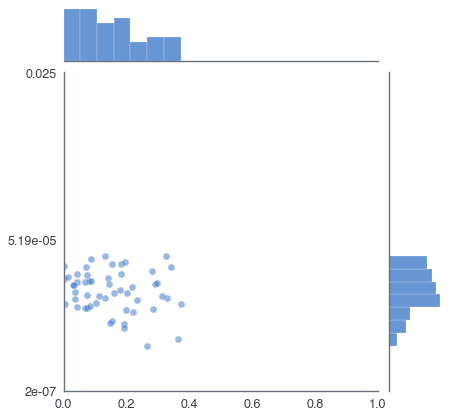

In [50]:
g = sns.jointplot(x=df_fit.beta.values, y=np.log(df_fit.alpha.values),
                  joint_kws = dict(alpha=0.5,))
ax = g.ax_joint
ax.set_ylim((np.log(2e-07), np.log(0.025)))
ax.set_yticks(np.log([2e-07, 5.19e-05, 0.025]))
ax.set_yticklabels(("2e-07", "5.19e-05", "0.025"))

ax.set_xlim((0, 1))

# Item-user pair level

In [52]:
def objective(
        param,
        success,
        timestamp,
        eps=np.finfo(np.float).eps):
    
    a, b = param

    rep = timestamp
    n = len(rep)

    log_p_item = np.zeros(n)
    # first presentation is success for sure

    delta_rep = rep[1:] - rep[:n-1]
    n_pres = np.arange(1, n)

    fr = a * (1 - b) ** (n_pres - 1)
    log_p_item[1:] = -fr * delta_rep
    
    p_ = np.exp(log_p_item)
    failure = np.invert(success)
    p_[failure] = 1 - p_[failure]
    _log_lik = np.log(p_ + eps)
    sum_ll = _log_lik.sum()
    return - sum_ll


def optimize(item_df):
    
    item_df.sort_values(by="timestamp")

    success = item_df["success"].values.astype(bool)
    timestamp = item_df["timestamp"].values
    
    # Define bounds and an initial guess
    n_param = 2
    bounds = [(2e-07, 0.025), (0, 1)]
    init_guess = ((0.01, 0.5))

    # Run the optimizer
    res = scipy.optimize.minimize(
        fun=objective,
        x0=init_guess,
        bounds=bounds,
        args=((success, timestamp)))
    return res

In [53]:
r = []

for user, user_df in tqdm(df.groupby("user")):  
    for item, item_df in df.groupby("item"):
        
        res = optimize(item_df)
        r.append({"user": user, "item": item, "alpha": res.x[0], "beta": res.x[1]})

df_fit_item = pd.DataFrame(r)
df_fit_item

  0%|          | 0/53 [00:00<?, ?it/s]<ipython-input-52-9cdbc5e471a3>:21: RuntimeWarning: overflow encountered in exp
  p_ = np.exp(log_p_item)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 53/53 [07:17<00:00,  8.26s/it]


,user,item,alpha,beta
0,ageratum@active.fi,1,0.010000,0.500000
1,ageratum@active.fi,2,0.010000,0.500000
2,ageratum@active.fi,3,0.010000,0.500000
3,ageratum@active.fi,4,0.010000,0.500000
4,ageratum@active.fi,5,0.000591,0.637700
...,...,...,...,...
105889,vulture@active.fi,2051,0.000006,0.000000
105890,vulture@active.fi,2052,0.010000,0.500000
105891,vulture@active.fi,2053,0.010000,0.500000
105892,vulture@active.fi,2054,0.010000,0.500000


(0.0, 1.0)

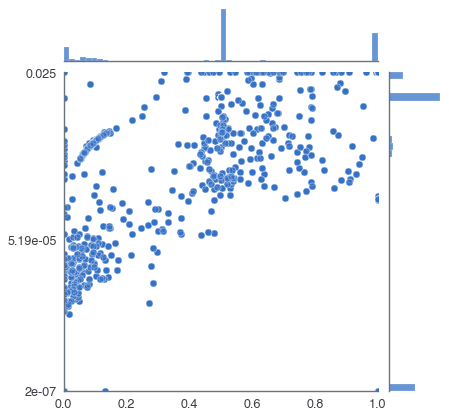

In [54]:
g = sns.jointplot(x=df_fit_item.beta.values, y=np.log(df_fit_item.alpha.values),
                  joint_kws = dict(alpha=0.5,))
ax = g.ax_joint
ax.set_ylim((np.log(2e-07), np.log(0.025)))
ax.set_yticks(np.log([2e-07, 5.19e-05, 0.025]))
ax.set_yticklabels(("2e-07", "5.19e-05", "0.025"))

ax.set_xlim((0, 1))

                     user  item     alpha      beta
57942  goldfish@active.fi     1  0.010000  0.500000
57943  goldfish@active.fi     2  0.010000  0.500000
57944  goldfish@active.fi     3  0.010000  0.500000
57945  goldfish@active.fi     4  0.010000  0.500000
57946  goldfish@active.fi     5  0.000591  0.637700
...                   ...   ...       ...       ...
59935  goldfish@active.fi  2051  0.000006  0.000000
59936  goldfish@active.fi  2052  0.010000  0.500000
59937  goldfish@active.fi  2053  0.010000  0.500000
59938  goldfish@active.fi  2054  0.010000  0.500000
59939  goldfish@active.fi  2055  0.000085  0.143114

[1998 rows x 4 columns]
                user  item     alpha      beta
53946  fox@active.fi     1  0.010000  0.500000
53947  fox@active.fi     2  0.010000  0.500000
53948  fox@active.fi     3  0.010000  0.500000
53949  fox@active.fi     4  0.010000  0.500000
53950  fox@active.fi     5  0.000591  0.637700
...              ...   ...       ...       ...
55939  fox@active.fi  

                   user  item     alpha      beta
41958  cuckoo@active.fi     1  0.010000  0.500000
41959  cuckoo@active.fi     2  0.010000  0.500000
41960  cuckoo@active.fi     3  0.010000  0.500000
41961  cuckoo@active.fi     4  0.010000  0.500000
41962  cuckoo@active.fi     5  0.000591  0.637700
...                 ...   ...       ...       ...
43951  cuckoo@active.fi  2051  0.000006  0.000000
43952  cuckoo@active.fi  2052  0.010000  0.500000
43953  cuckoo@active.fi  2053  0.010000  0.500000
43954  cuckoo@active.fi  2054  0.010000  0.500000
43955  cuckoo@active.fi  2055  0.000085  0.143114

[1998 rows x 4 columns]
                     user  item     alpha      beta
61938  kangaroo@active.fi     1  0.010000  0.500000
61939  kangaroo@active.fi     2  0.010000  0.500000
61940  kangaroo@active.fi     3  0.010000  0.500000
61941  kangaroo@active.fi     4  0.010000  0.500000
61942  kangaroo@active.fi     5  0.000591  0.637700
...                   ...   ...       ...       ...
63931  kang

                    user  item     alpha      beta
0     ageratum@active.fi     1  0.010000  0.500000
1     ageratum@active.fi     2  0.010000  0.500000
2     ageratum@active.fi     3  0.010000  0.500000
3     ageratum@active.fi     4  0.010000  0.500000
4     ageratum@active.fi     5  0.000591  0.637700
...                  ...   ...       ...       ...
1993  ageratum@active.fi  2051  0.000006  0.000000
1994  ageratum@active.fi  2052  0.010000  0.500000
1995  ageratum@active.fi  2053  0.010000  0.500000
1996  ageratum@active.fi  2054  0.010000  0.500000
1997  ageratum@active.fi  2055  0.000085  0.143114

[1998 rows x 4 columns]
                      user  item     alpha      beta
1998  alchemilla@active.fi     1  0.010000  0.500000
1999  alchemilla@active.fi     2  0.010000  0.500000
2000  alchemilla@active.fi     3  0.010000  0.500000
2001  alchemilla@active.fi     4  0.010000  0.500000
2002  alchemilla@active.fi     5  0.000591  0.637700
...                    ...   ...       ...   

(0.0, 1.0)

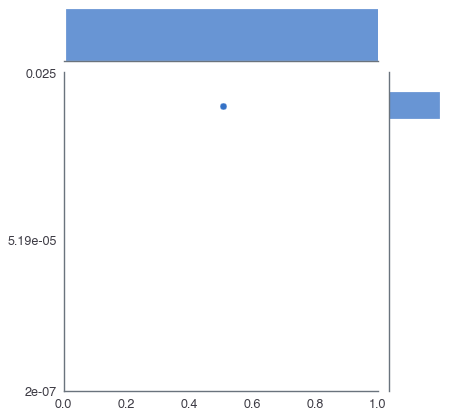

In [55]:
n_user = len(df.user.unique())

alphas_u = np.zeros(n_user)
betas_u = np.zeros(n_user)

for i, u in enumerate(df.user.unique()):
    df_u = df_fit_item[df_fit_item.user == u]
    print(df_u)
    alphas_u[i] = np.mean(df_u.alpha.values)
    betas_u[i] = np.mean(df_u.beta.values)
    
g = sns.jointplot(x=betas_u, y=np.log(alphas_u),
                  joint_kws = dict(alpha=0.5,))
ax = g.ax_joint
ax.set_ylim((np.log(2e-07), np.log(0.025)))
ax.set_yticks(np.log([2e-07, 5.19e-05, 0.025]))
ax.set_yticklabels(("2e-07", "5.19e-05", "0.025"))

ax.set_xlim((0, 1))

(0.0, 1.0)

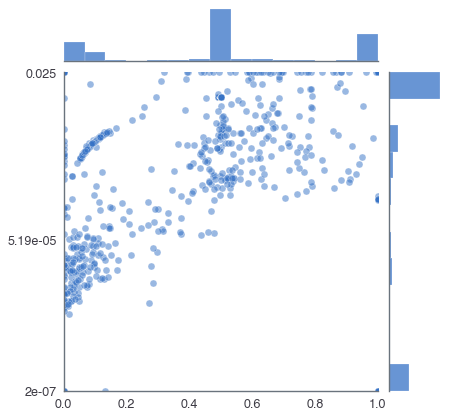

In [56]:
n_item = len(df.item.unique())

alphas_i = np.zeros(n_item)
betas_i = np.zeros(n_item)

for i, it in enumerate(df.item.unique()):
    df_i = df_fit_item[df_fit_item.item == it]
    alphas_i[i] = np.mean(df_i.alpha.values)
    betas_i[i] = np.mean(df_i.beta.values)
    
g = sns.jointplot(x=betas_i, y=np.log(alphas_i),
                  joint_kws = dict(alpha=0.5,))
ax = g.ax_joint
ax.set_ylim((np.log(2e-07), np.log(0.025)))
ax.set_yticks(np.log([2e-07, 5.19e-05, 0.025]))
ax.set_yticklabels(("2e-07", "5.19e-05", "0.025"))

ax.set_xlim((0, 1))

In [57]:
print(n_item)

1998


# Item level

In [58]:
def objective(param, df):
    
    a, b = param
    
    sum_ll = 0
    
    for user, user_df in df.groupby("user"):
        
        n = len(user_df)
        
        if n > 1:
            user_df.sort_values(by="timestamp")
            
            # first presentation is success for sure
            success = user_df["success"].values.astype(bool)[1:]
            timestamp = user_df["timestamp"].values

            delta_rep = timestamp[1:] -timestamp[:n-1]
            n_pres = np.arange(1, n)

            fr = a * (1 - b) ** (n_pres - 1)
            lp = -fr * delta_rep
            
            failure = np.invert(success)
            
            lp[failure] = np.log(1 - np.exp(lp[failure])) 

            sum_ll += lp.sum()
    
    return - sum_ll


def optimize(item_df):
    
    # Define bounds and an initial guess
    n_param = 2
    bounds = [(2e-07, 0.025), (0, 1)]
    init_guess = ((0.01, 0.5))

    # Run the optimizer
    res = scipy.optimize.minimize(
        fun=objective,
        x0=init_guess,
        bounds=bounds,
        args=(item_df, )
    )
    return res

r = []

for item, item_df in tqdm(df.groupby("item")):
        
    res = optimize(item_df)
    r.append({"item": item, "alpha": res.x[0], "beta": res.x[1]})

df_fit_item = pd.DataFrame(r)
df_fit_item

  0%|          | 4/1998 [00:00<00:51, 38.78it/s]<ipython-input-58-23a3ed483aca>:26: RuntimeWarning: divide by zero encountered in log
  lp[failure] = np.log(1 - np.exp(lp[failure]))
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 1998/1998 [01:24<00:00, 23.72it/s]


,item,alpha,beta
0,1,2.000000e-07,1.0
1,2,2.000000e-07,1.0
2,3,2.000000e-07,1.0
3,4,2.000000e-07,1.0
4,5,1.000000e-02,0.5
...,...,...,...
1993,2051,1.000000e-02,0.5
1994,2052,1.000000e-02,0.5
1995,2053,1.000000e-02,0.5
1996,2054,1.000000e-02,0.5


n=1998


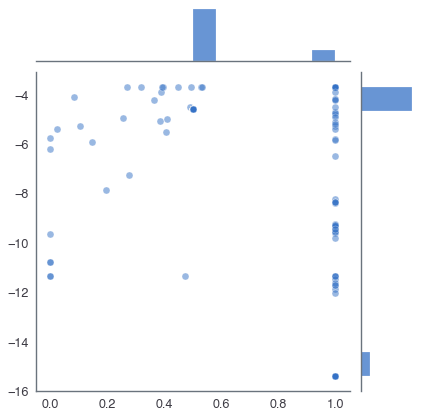

In [59]:
g = sns.jointplot(x=df_fit_item.beta.values, y=np.log(df_fit_item.alpha.values),
                  joint_kws = dict(alpha=0.5,))
ax = g.ax_joint
# ax.set_ylim((np.log(2e-07), np.log(0.025)))
# ax.set_yticks(np.log([2e-07, 5.19e-05, 0.025]))
# ax.set_yticklabels(("2e-07", "5.19e-05", "0.025"))

# ax.set_xlim((0, 1))

print(f"n={len(df_fit_item)}")

# Bayesian Inference

In [94]:
import theano.tensor as tt

In [191]:
def optimize(user_df):
    with pm.Model() as model:

        hist = user_df["item"].values
        success = user_df["success"].values.astype(bool)
        timestamp = user_df["timestamp"].values
        
        user_df.sort_values(by="timestamp", inplace=True)
            
        # α = pm.Lognormal('α', 0.5, 0.2) # pm.Uniform('α', lower=2e-07, upper=0.025)
        # β = pm.Normal('β', 0, 1)  # pm.Uniform('β', lower=0.0001, upper=0.9999)
    
        # α = pm.Bound(pm.Normal, lower=0.0)('α', mu=0.1, sigma=1.0)
        # β = pm.Beta('β', alpha=2.0, beta=2.0)
        # β = pm.Lognormal('β', 0.5, 0.2)
        
        α = pm.Uniform('α', lower=2e-07, upper=0.025)
        β = pm.Uniform('β', lower=0.0001, upper=0.9999)
        
        len_hist = len(hist)
        
        n_pres = np.zeros(len_hist) 
        delta_rep = np.zeros(len_hist)
        
        items = np.unique(hist)
        
        n_item = len(items)
        
        # For each item
        for item in items:

            is_item = hist == item
            rep = timestamp[is_item]
            n = len(rep)
            
            n_pres[is_item] = np.arange(n)
            delta_rep[is_item] = np.concatenate(([0], rep[1:] - rep[:n-1]))
        
        n_rep = n_pres - 1
        
        not_first_pres = n_pres != 0
        
        delta_rep = delta_rep[not_first_pres]
        n_rep = n_rep[not_first_pres]
        success = success[not_first_pres]
                
        p = pm.math.exp( -(α * (1 - β) ** n_rep) * delta_rep) + np.finfo(float).eps
        
        recall = pm.Bernoulli('recall', p=p, observed=success)
        
    with model:
        trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)
    return az.summary(trace)

In [192]:
r = []

for user, user_df in tqdm(df.groupby("user")):
    res = optimize(user_df)
    r.append({"user": user, "alpha": res.loc["α", "mean"], "beta": res.loc["β", "mean"]})

df_fit = pd.DataFrame(r)
df_fit

  0%|          | 0/53 [00:00<?, ?it/s]

[6.19800003e+01 1.16744000e+02 1.15660000e+02 1.38515000e+02
 1.54035000e+02 1.59936000e+02 1.59351000e+02 1.62154000e+02
 1.62105000e+02 1.65104000e+02 1.63404000e+02 1.61772000e+02
 1.59319000e+02 1.61569000e+02 1.34131000e+02 1.11241000e+02
 1.00955000e+02 9.85389998e+01 9.77910001e+01 9.65039999e+01
 1.07908000e+02 1.07390000e+02 1.03256000e+02 9.78720002e+01
 1.02773000e+02 9.78540001e+01 1.05073000e+02 1.12941000e+02
 1.13792000e+02 1.61870000e+01 1.36870003e+01 1.83710001e+01
 1.84700000e+01 1.60539999e+01 1.55539999e+01 1.44520001e+01
 1.80519998e+01 1.61870000e+01 1.34370000e+01 9.80199981e+00
 1.48540001e+01 1.81369998e+01 1.05699999e+01 2.61400001e+01
 2.93900001e+01 3.24900000e+01 8.56308840e+04 8.56412880e+04
 8.56440360e+04 8.56403870e+04 8.56213990e+04 8.56389870e+04
 8.56484060e+04 8.56588400e+04 8.56607070e+04 8.61849999e+01
 8.70529997e+01 8.98539999e+01 8.74869998e+01 9.75550001e+01
 9.55720000e+01 9.32380002e+01 8.59020000e+01 1.08008000e+02
 1.09074000e+02 1.098250

/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
  0%|          | 0/53 [00:22<?, ?it/s]


KeyboardInterrupt: 